#Mounting Google Drive

In [ ]:
####### Mouting Drive #######
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
archive  drive	sample_data


#Unzip all Images

In [ ]:
!unzip "/content/drive/MyDrive/PIDL-Brain-Tumor/archive (1).zip"

Archive:  /content/drive/MyDrive/PIDL-Brain-Tumor/archive (1).zip
replace archive/Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Existing imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as pi
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.losses import categorical_crossentropy
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [ ]:
IMAGE_SIZE = [224, 224]
train_path = '/content/archive/Training'
valid_path = '/content/archive/Testing'

vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(glob('/content/archive/Testing/*')), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)


In [ ]:
def physics_informed_loss(y_true, y_pred, alpha=0.1):
    classification_loss = categorical_crossentropy(y_true, y_pred)
    physics_loss = physics_model(y_pred)  # Physics loss based on predicted tumor size
    combined_loss = classification_loss + alpha * physics_loss
    return combined_loss

def physics_model(y_pred):
    # Hypothetical physics-based loss
    # Larger predicted sizes should have lower growth rates (simplified assumption)
    predicted_size = tf.reduce_mean(y_pred, axis=1)  # Simplified representation of size
    growth_rate_penalty = tf.square(predicted_size)  # Penalize larger sizes
    physics_loss = tf.reduce_mean(growth_rate_penalty)
    return physics_loss


In [ ]:
model.compile(
    optimizer='adam',
    loss=lambda y_true, y_pred: physics_informed_loss(y_true, y_pred, alpha=0.1),
    metrics=['accuracy']
)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size=32, class_mode='categorical')

history = model.fit(train_generator, validation_data=validation_generator, epochs=30, steps_per_epoch=len(train_generator), validation_steps=len(validation_generator))


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/30
179/179 [==============================] - 114s 569ms/step - loss: 0.5026 - accuracy: 0.8121 - val_loss: 0.3666 - val_accuracy: 0.8558
Epoch 2/30
179/179 [==============================] - 86s 478ms/step - loss: 0.2933 - accuracy: 0.8957 - val_loss: 0.3468 - val_accuracy: 0.8711
Epoch 3/30
179/179 [==============================] - 91s 507ms/step - loss: 0.2359 - accuracy: 0.9179 - val_loss: 0.3123 - val_accuracy: 0.8947
Epoch 4/30
179/179 [==============================] - 84s 466ms/step - loss: 0.2097 - accuracy: 0.9244 - val_loss: 0.3217 - val_accuracy: 0.8734
Epoch 5/30
179/179 [==============================] - 84s 470ms/step - loss: 0.1837 - accuracy: 0.9361 - val_loss: 0.2133 - val_accuracy: 0.9283
Epoch 6/30
179/179 [==============================] - 84s 469ms/step - loss: 0.1689 - accuracy: 0.9408 - val_loss: 0.2256 - val_accuracy: 0.9199
Epoch 7/30
179/179 [=========================

Confusion matrix

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Create a Sequential model
model = Sequential()

# Add a convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
# Add a max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))
# Add another max-pooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the output from the previous layer
model.add(Flatten())

# Add a fully connected layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))
# Add dropout for regularization
model.add(Dropout(0.5))

# Add the output layer with as many units as classes and softmax activation for classification
# Replace `num_classes` with the number of classes in your dataset
num_classes = 4  # Example for 4 classes (glioma, meningioma, no tumor, pituitary)
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model's architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_1 (Dense)             (None, 128)               2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory where your training and validation data are stored
train_data_dir = '/content/archive/Training'
validation_data_dir = '/content/archive/Testing'

# Create data generators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    shear_range=0.2,    # Random shear transformations
    zoom_range=0.2,     # Random zoom transformations
    horizontal_flip=True  # Random horizontal flips
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)  # Only rescale for validation

# Define batch size and image dimensions
batch_size = 32
image_height = 224
image_width = 224

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
epochs = 30  # Choose the number of training epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(validation_generator, steps=len(validation_generator))
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/30
179/179 [==============================] - 91s 480ms/step - loss: 1.0080 - accuracy: 0.5900 - val_loss: 0.9037 - val_accuracy: 0.7185
Epoch 2/30
179/179 [==============================] - 84s 469ms/step - loss: 0.6167 - accuracy: 0.7663 - val_loss: 0.6740 - val_accuracy: 0.7529
Epoch 3/30
179/179 [==============================] - 82s 456ms/step - loss: 0.5338 - accuracy: 0.7939 - val_loss: 0.5977 - val_accuracy: 0.7757
Epoch 4/30
179/179 [==============================] - 85s 475ms/step - loss: 0.4820 - accuracy: 0.8183 - val_loss: 0.4709 - val_accuracy: 0.8017
Epoch 5/30
179/179 [==============================] - 84s 468ms/step - loss: 0.4304 - accuracy: 0.8365 - val_loss: 0.4985 - val_accuracy: 0.8085
Epoch 6/30
179/179 [==============================] - 81s 454ms/step - loss: 0.4057 - accuracy: 0.8482 - val_loss: 0.4696 - val_accuracy: 0.8207
Epoch 7/30
179/179 [==========================

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights when training stops
)

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]  # Add the early stopping callback
)


Epoch 1/30
179/179 [==============================] - 86s 481ms/step - loss: 0.1546 - accuracy: 0.9412 - val_loss: 0.1569 - val_accuracy: 0.9352
Epoch 2/30
179/179 [==============================] - 87s 484ms/step - loss: 0.1564 - accuracy: 0.9438 - val_loss: 0.1548 - val_accuracy: 0.9367
Epoch 3/30
179/179 [==============================] - 81s 455ms/step - loss: 0.1604 - accuracy: 0.9410 - val_loss: 0.1754 - val_accuracy: 0.9268
Epoch 4/30
179/179 [==============================] - 85s 472ms/step - loss: 0.1497 - accuracy: 0.9456 - val_loss: 0.1379 - val_accuracy: 0.9443
Epoch 5/30
179/179 [==============================] - 83s 464ms/step - loss: 0.1512 - accuracy: 0.9449 - val_loss: 0.1552 - val_accuracy: 0.9413
Epoch 6/30
179/179 [==============================] - 82s 454ms/step - loss: 0.1385 - accuracy: 0.9468 - val_loss: 0.1485 - val_accuracy: 0.9321
Epoch 7/30
179/179 [==============================] - 87s 486ms/step - loss: 0.1330 - accuracy: 0.9487 - val_loss: 0.1342 - val_ac

In [ ]:
# Example multi-output model architecture
classification_output = Dense(num_classes, activation='softmax', name='classification')(x)
physics_output = Dense(1, activation='linear', name='physics')(x)  # Adjust as needed
model = Model(inputs=vgg.input, outputs=[classification_output, physics_output])


In [ ]:
classification_loss = 'categorical_crossentropy'
physics_loss = 'mean_squared_error'  # Adjust as needed


In [ ]:
loss_weights = {'classification': 1.0, 'physics': 0.1}  # Adjust weights as needed


In [ ]:
model.compile(
    optimizer='adam',
    loss={'classification': classification_loss, 'physics': physics_loss},
    loss_weights=loss_weights,
    metrics={'classification': 'accuracy', 'physics': 'mae'}  # Adjust metrics as needed
)


Epoch 1/30
179/179 [==============================] - 97s 520ms/step - loss: 0.5399 - classification_loss: 0.4950 - physics_loss: 0.4490 - classification_accuracy: 0.8139 - physics_mae: 0.4928 - val_loss: 0.3875 - val_classification_loss: 0.3661 - val_physics_loss: 0.2144 - val_classification_accuracy: 0.8696 - val_physics_mae: 0.3420
Epoch 2/30
179/179 [==============================] - 96s 538ms/step - loss: 0.3107 - classification_loss: 0.2898 - physics_loss: 0.2085 - classification_accuracy: 0.8943 - physics_mae: 0.3793 - val_loss: 0.2710 - val_classification_loss: 0.2510 - val_physics_loss: 0.2005 - val_classification_accuracy: 0.9123 - val_physics_mae: 0.3745
Epoch 3/30
179/179 [==============================] - 95s 527ms/step - loss: 0.2619 - classification_loss: 0.2414 - physics_loss: 0.2049 - classification_accuracy: 0.9109 - physics_mae: 0.3778 - val_loss: 0.3931 - val_classification_loss: 0.3716 - val_physics_loss: 0.2153 - val_classification_accuracy: 0.8757 - val_physics_m

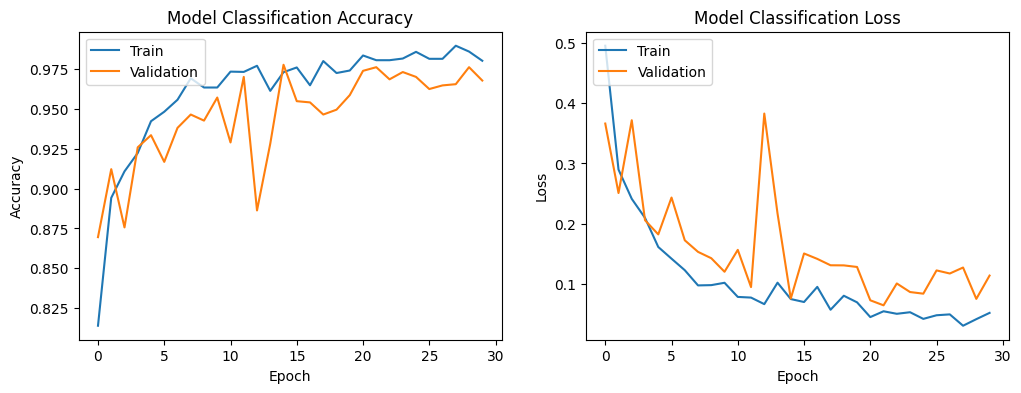

In [ ]:
# Training the multi-task model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Evaluate the multi-task model
eval_metrics = model.evaluate(validation_generator, steps=len(validation_generator))
classification_loss, physics_loss, classification_accuracy = eval_metrics[1], eval_metrics[2], eval_metrics[3]

print("Validation Classification Loss:", classification_loss)
print("Validation Physics Loss:", physics_loss)
print("Validation Classification Accuracy:", classification_accuracy)

# Visualization: Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_accuracy'])
plt.plot(history.history['val_classification_accuracy'])
plt.title('Model Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_loss'])
plt.plot(history.history['val_classification_loss'])
plt.title('Model Classification Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


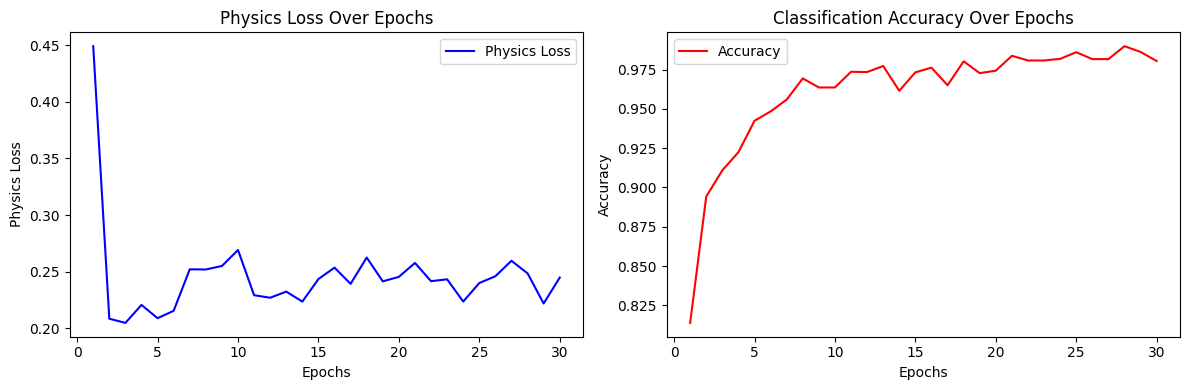

In [ ]:
import matplotlib.pyplot as plt

# Extract the physics loss and accuracy from your model's history
physics_loss = history.history['physics_loss']  # Replace with the actual name of your physics loss
accuracy = history.history['classification_accuracy']  # Replace with the actual name of your classification accuracy

# Create subplots to visualize both physics loss and accuracy
plt.figure(figsize=(12, 4))

# Plot physics loss
plt.subplot(1, 2, 1)
epochs = range(1, len(physics_loss) + 1)
plt.plot(epochs, physics_loss, 'b', label='Physics Loss')
plt.title('Physics Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Physics Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Accuracy')
plt.title('Classification Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 162ms/step


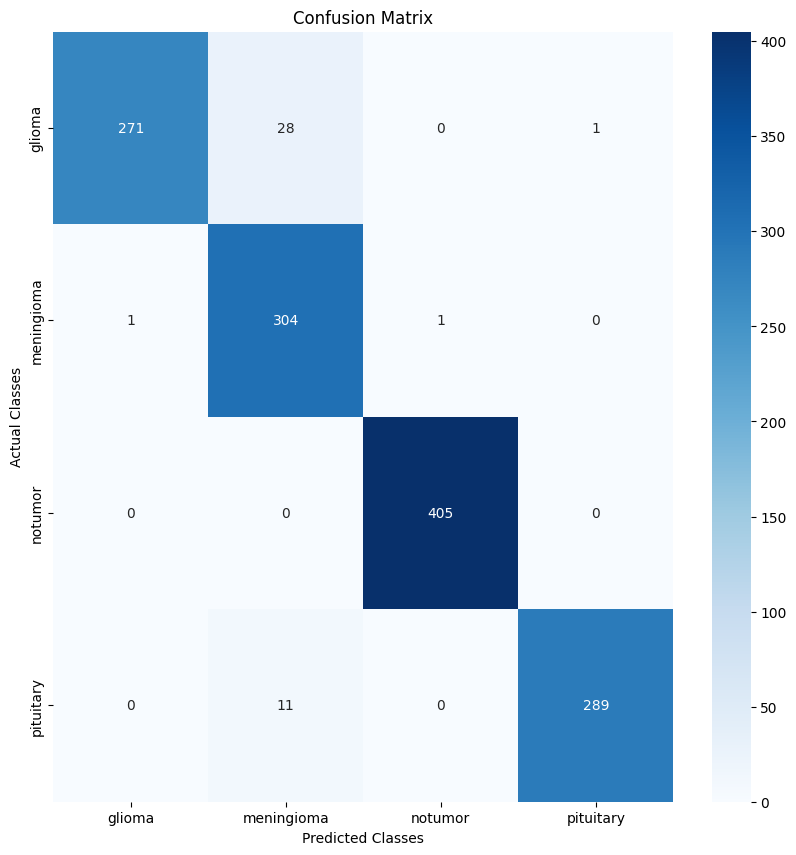

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize arrays to store true and predicted labels
true_labels = []
pred_labels = []

# Iterate over all batches in the validation generator
for _ in range(len(validation_generator)):
    val_images, val_labels = next(validation_generator)
    # Generate predictions
    predictions = model.predict(val_images)
    # Extract only classification predictions (assuming it's the first element in the list)
    classification_predictions = predictions[0]
    # Convert predictions to class indices
    predicted_classes = np.argmax(classification_predictions, axis=1)
    true_classes = np.argmax(val_labels, axis=1)
    # Store true and predicted labels
    true_labels.extend(true_classes)
    pred_labels.extend(predicted_classes)

# Convert lists to arrays for sklearn functions
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Define class labels if you have custom class names
class_labels = ["glioma", "meningioma", "notumor", "pituitary"]  # Replace with your class names

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


In [ ]:
!pip install shap
!pip install tensorflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.0 MB/s eta 0:00:00


In [ ]:
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [ ]:

import numpy as np
import tensorflow as tf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


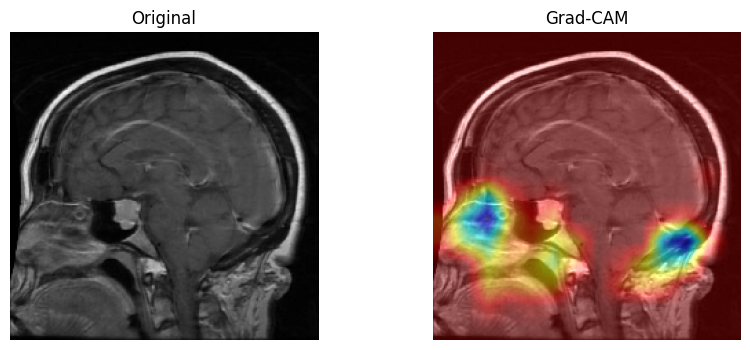

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2  # For heatmap visualization
from tensorflow.keras.preprocessing import image

# Define Grad-CAM algorithm
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output] + [model.output]
    )

    with tf.GradientTape() as tape:
        outputs = grad_model(img_array)
        last_conv_layer_output = outputs[0]
        preds = outputs[1]

        if pred_index is None:
            pred_index = tf.argmax(preds[0][0])
        top_class_channel = preds[0][:, pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image function
def overlay_heatmap_on_image(img, heatmap, alpha=0.5):
    # Resize heatmap to match the shape of the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply color map to heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original image
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img


# Load your trained model
# model = ... (load or define your model here)

# Load and preprocess the image
img_path = '/content/archive/Testing/pituitary/Te-piTr_0005.jpg'  # replace with your image path
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
original_img = np.copy(img_array)  # Keep a copy of the original image for overlay
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image as done during training

# Specify the last convolutional layer name
last_conv_layer_name = 'block5_conv3'  # Adjust based on your model

# Generate the heatmap for a specific image
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Overlay the heatmap on original image
overlay_img = overlay_heatmap_on_image(original_img, heatmap)

# Display original image and heatmap overlay side by side
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img / 255.0)  # Original image
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(overlay_img)  # Heatmap overlay
plt.title("Grad-CAM")
plt.axis('off')

plt.show()